In [644]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [641]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

Для начала загрузим наша датасет. (https://www.kaggle.com/laotse/credit-risk-dataset)

In [10]:
df = pd.read_csv('credit_risk_dataset.csv')

Посмотрим на первые 5 строчек, что бы убедиться что датасет загрузился нормально.

In [13]:
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


Посмотрим на количество пропущенных значений по каждому признаку.

In [299]:
df.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

Как видим в нашем датасете пропущенные значения имеют только признаки person_emp_length и loan_in_rate, восстановлением которых мы и будем заниматься. Заметим, что оба признаки являются числовыми, что по большей части развязывает нам руки в использывании различных методов заполнения пропущенных значений, но некоторую проблему составляют другие категориальные описания наших объектов, ниже рассмотрим возможные способы преодоления этой трудности.  

Посмотрим какую доля от всех наблюдений состовляют пропущенные значенния.

In [297]:
count_person_emp_length_na = (df['person_emp_length'].isnull() > 0).sum()
print('percent nan of person_emp_length feature = %.2f' % (count_person_emp_length_na / df.shape[0]))
count_loan_int_rate_na = (df['loan_int_rate'].isnull() > 0).sum()
print('percent nan of loan_int_rate feature = %.2f' % (count_loan_int_rate_na / df.shape[0]))

percent nan of person_emp_length feature = 0.03
percent nan of loan_int_rate feature = 0.10


Как видим выше признак ***person_emp_length*** имеет всего 3 процента пропущенных значений, который предположительно мы сможем восстанавливать достаточного хорошо, по той очевидной причины что мы имеем больше информации для обучения нашего метода заполнения пропущенных значений, чуть более хуже ситуация обстоит с признаком ***loan_int_rate***, который имеет 10 процентов не заполненных значений.

Опишем как будет работать функция, которая занимается подсчетом метрика качества (в нашем случае это будет mse) способа заполнения пропущенных значений. Изначально мы избавимся от всех наблюдений (строчек в датасете) которые по некоторому признаку имеют N/A, так как это является проблемой для метрических алгоритмов и если по нашему признаку отсутствует значение для обучения такие объекты не несут никакой дополнительной информации. Далее что бы получить более менее адеквытные оценки качества (избежать переобучения) будем обучаться на кросс-валидации, будем использовать кросс-валидацию с 10 фолдами, то есть наш датасет будет 10 раз разбиваться на train и test в соотношении 9 к 1, потом мы на трайне и тесты выкидует по percent_missing (параметр функции, который отвечает за процент объектов выбор, о которым мы "забываем" информацию по данной фиче) процентов объектов от их размера, на трайне обучаем наш алгоритм заполнения пропущенныех данных, потом делаем предсказание на тесте, в котором затерты настоящие значения, далее берем вектор признаков из теста с настоящими значениями и вектор признаков с предсказаными значения, выкидуем из обеих векторов элементы которые мы не предсказывали, считаем mse и в итоге усредняем по все фолдам.

Сама функция test_imputer принимает в себя наш дасасет, imputer - который реализует интерфейс fit/transform, имя признака в DataFrame, далее индекс признака и процент пропущенных значений.

In [573]:
def test_imputer(dataframe, imputer, feature_name, feature_column_number, percent_missing):
    df_free_na = dataframe.dropna()
    values = []
    kfold = KFold(n_splits=10)
    for train_index, test_index in kfold.split(df_free_na):
        X_train, X_test = df_free_na.iloc[train_index], df_free_na.iloc[test_index]
        train_drop_na_idx = np.random.choice(X_train.shape[0], int(X_train.shape[0] * percent_missing),
                                            replace=False)
        test_drop_na_idx = np.random.choice(X_test.shape[0], int(X_test.shape[0] * percent_missing),
                                           replace=False)
        X_train_drop_na = X_train.copy()
        X_test_drop_na = X_test.copy()
        X_train_drop_na.iloc[train_drop_na_idx, X_train_drop_na.columns.get_loc(feature_name)] = np.nan
        X_test_drop_na.iloc[test_drop_na_idx, X_test_drop_na.columns.get_loc(feature_name)] = np.nan
        
        imputer.fit(X_train_drop_na)
        X_predict = imputer.transform(X_test_drop_na)
        predict_values = X_predict[:, feature_column_number]
        true_values = X_test.iloc[:, X_test.columns.get_loc(feature_name)]
        predict_values = predict_values[test_drop_na_idx]
        true_values = np.array(true_values)[test_drop_na_idx]
        values.append(mean_squared_error(true_values, predict_values))
    return np.mean(values)

Теперь когда мы имеем инструмент для подсчета метрика качества алгоритма заполнения пропущенных значений, мы можем занять непосредственным их тестированием.

Рассмотри два наивных imputer: ***SimpleImputer(strategy='mean')*** и ***SimpleImputer(strategy='median')***. Первый занимается тем, что меняет пропущенное значение признака, на средние значение это признака на трайне, второй действует аналогично, только вместо среднего использует моду.

И также рассмотри не такой тривиальный imputer: ***KNNImputer(n_neighbor=5)***, который занимается тем что для объекта у которого пропущенного значение признакка, он находит 5 ближайних объектов в трайне и усредняет значение признака по ним.


И так как KKNImputer является метрическим алгоритмов, появляется проблема о которой упоминалось выше, а именно работа с категориальными признаками. Используя тривиальный метод перенумерацию категориальных признаком мы можем попасть в неприятные ситуации, которые сильно ухудшать работу любого метрического алгоритма. Стоит начать с того, если на категориальных объектах не было задано отношения порядка, то при перенумерации она появлятся, и теперь на некоторые значения признака можно смотреть как на более значимые чем другие, хотя изначально такого свойста не наблюдалось. И второй важный момент это порядки величин, при перенумираци и нас появятся значения по признаку $1, 2, ..., N$, в том время как другие вещественные значение могут имеет значения в некой небольшой окрестности некоторого числа, очевидно с такой проблемой стоит бороться с помощью нормировки, но все же это не решает проблемы что величина признака соответствует его важности, и в такой постановку невозможно решать задачу минимизации / максимизации. 

Посмотрим какие значения имеют наши признаки.

In [582]:
df.dtypes

person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_status                     int64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
dtype: object

Выделим числовые признаки.

In [606]:
numerical_feature_names = []
for feature_name in df.dtypes.index:
    if df.dtypes[feature_name] in ['int64', 'float64']:
        numerical_feature_names.append(feature_name)

In [607]:
df_numerical = df[numerical_feature_names]

Посмотрим на наш датасет, который состоит только из числовых признаков:

In [608]:
df_numerical.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
0,22,59000,123.0,35000,16.02,1,0.59,3
1,6,1,1.0,1,1.00,1,1.00,1
2,6,1,1.0,1,1.00,1,1.00,1
3,6,1,1.0,1,1.00,1,1.00,1
4,6,1,1.0,1,1.00,1,1.00,1


Теперь отнормируем данные.

In [622]:
scaler = StandardScaler()
df_numerical = pd.DataFrame(scaler.fit_transform(df_numerical), columns=df_numerical.columns)

Пока не будем трогать признаки ***loan_int_rate*** и ***person_emp_length***, которые имеют пропуски в изначальной выборке, а протестируем алгоритмы на признаках ***person_income*** и ***loan_amnt***.

Для избежания зависимости от разбиения на кросс-валидации проведем каждый эксперимент 5 раз и усредним результаты.

In [751]:
missing_level = [0.05, 0.1, 0.15]
score_result_second = np.zeros((len(missing_level), 2))
count_test = 5
for idx_test in range(count_test):
    for idx, percent_missing in enumerate(missing_level):
        score_result_second[idx][0] += test_imputer(df_numerical, SimpleImputer(strategy='mean'), 'person_income',
                                             df_numerical.columns.get_loc('person_income'), percent_missing)
        score_result_second[idx][1] += test_imputer(df_numerical, SimpleImputer(strategy='mean'), 'loan_amnt',
                                             df_numerical.columns.get_loc('loan_amnt'), percent_missing)
score_result_second /= count_test

Построим график зависимости mse от процента пропущенных значений.

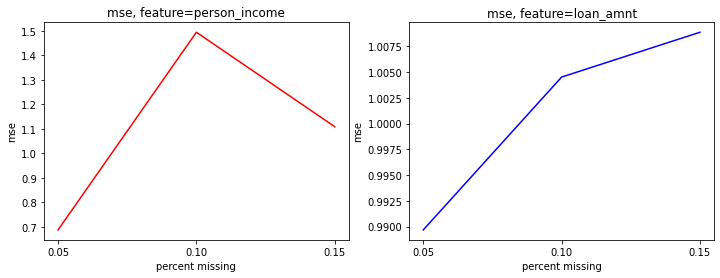

In [752]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title('mse, feature=person_income')
plt.xticks(missing_level)
plt.plot(missing_level, score_result_second[:, 0], c='red')
plt.xlabel("percent missing")
plt.ylabel("mse")

plt.subplot(1, 2, 2)
plt.xticks(missing_level)
plt.title('mse, feature=loan_amnt')
plt.plot(missing_level, score_result_second[:, 1], c='blue')
plt.xlabel("percent missing")
plt.ylabel("mse")

plt.show()

Как видим в зависимости от увеличения числа пропусков по признаку ***person_income*** растет mse, что и было вполне ожидаемо. Для признака ***loan_amnt*** мы имеем mse на уровне около 1 для всех возможных процентов пропущенных значений, это объясняется тем что мы используем самый примитивный метод (заполняем пропущенные значения средним), и он работает одинаково хорошо (или плохо) для полученных нами данных по этому признаку.

Теперь проведем аналогичные эксперименты для ***SimpleImputer(strategy='median')*** и для ***KNNImputer(n_neighbor=5)***. 

In [708]:
missing_level = [0.05, 0.1, 0.15]
score_result_first = np.zeros((len(missing_level), 2))
count_test = 5
for idx_test in range(count_test):
    for idx, percent_missing in enumerate(missing_level):
        score_result_first[idx][0] += test_imputer(df_numerical, SimpleImputer(strategy='median'), 'person_income',
                                             df_numerical.columns.get_loc('person_income'), percent_missing)
        score_result_first[idx][1] += test_imputer(df_numerical, SimpleImputer(strategy='median'), 'loan_amnt',
                                             df_numerical.columns.get_loc('loan_amnt'), percent_missing)
score_result_first /= count_test

Построим графики.

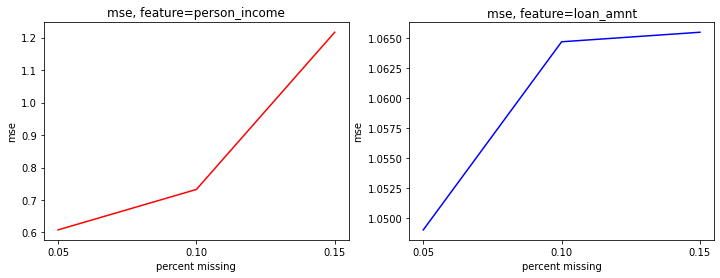

In [709]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title('mse, feature=person_income')
plt.xticks(missing_level)
plt.plot(missing_level, score_result_first[:, 0], c='red')
plt.xlabel("percent missing")
plt.ylabel("mse")

plt.subplot(1, 2, 2)
plt.xticks(missing_level)
plt.title('mse, feature=loan_amnt')
plt.plot(missing_level, score_result_first[:, 1], c='blue')
plt.xlabel("percent missing")
plt.ylabel("mse")

plt.show()

Как видим выше, мы получили аналогичную ситуацию с той что была раньше.

И теперь протестируем последний метод - ***KNNImputer***

In [700]:
missing_level = [0.05, 0.1, 0.15]
score_result = np.zeros((len(missing_level), 2))
count_test = 5
for idx_test in range(count_test):
    for idx, percent_missing in enumerate(missing_level):
        score_result[idx][0] += test_imputer(df_numerical, KNNImputer(n_neighbors=5), 'person_income',
                                             df_numerical.columns.get_loc('person_income'), percent_missing)
        score_result[idx][1] += test_imputer(df_numerical, KNNImputer(n_neighbors=5), 'loan_amnt',
                                             df_numerical.columns.get_loc('loan_amnt'), percent_missing)
score_result /= count_test

Построим графики.

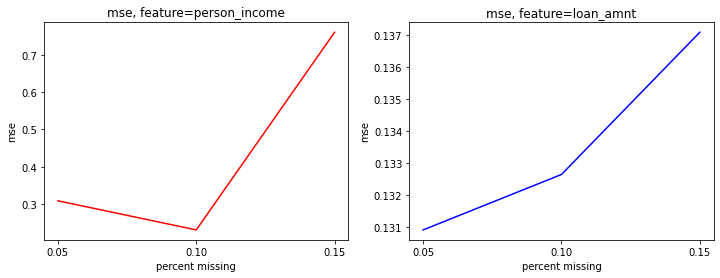

In [703]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title('mse, feature=person_income')
plt.xticks(missing_level)
plt.plot(missing_level, score_result[:, 0], c='red')
plt.xlabel("percent missing")
plt.ylabel("mse")

plt.subplot(1, 2, 2)
plt.xticks(missing_level)
plt.title('mse, feature=loan_amnt')
plt.plot(missing_level, score_result[:, 1], c='blue')
plt.xlabel("percent missing")
plt.ylabel("mse")

plt.show()

Как видим при потерях 0.05 - 0.10 mse держиться на уровне около 0.3 для признака ***person_income*** и далее растет при увеличении числа пропусков. Для признака ***loan_amnt*** mse имеет значение около 0.135 для всех уровеней "забывания данных".

Далее, что бы сравнивать наши алгоритмы восстановления пропусков в данных, построим графики зависимостей mse все на одном графике.

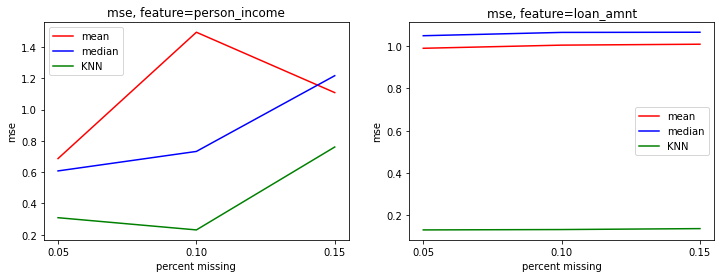

In [764]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.title('mse, feature=person_income')
plt.xticks(missing_level)
plt.xlabel("percent missing")
plt.ylabel("mse")
plt.plot(missing_level, score_result_second[:, 0], c='red', label='mean')
plt.plot(missing_level, score_result_first[:, 0], c='blue', label='median')
plt.plot(missing_level, score_result[:, 0], c='green', label='KNN')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('mse, feature=loan_amnt')
plt.xticks(missing_level)
plt.xlabel("percent missing")
plt.ylabel("mse")
plt.plot(missing_level, score_result_second[:, 1], c='red', label='mean')
plt.plot(missing_level, score_result_first[:, 1], c='blue', label='median')
plt.plot(missing_level, score_result[:, 1], c='green', label='KNN')
plt.legend()
plt.show()


Получаем вполне ожидаему картину, что для признака ***person_income*** лучше все восстанавливает пропуски KNN (для любого уровня пропущенных значений). По признаку ***loan_amnt*** ситуация обстоит таким образом, что в независимости от количества пропуской мы имеем примерно одинакой mse, но опять же лучше всего показывает себя KNNImputer. Можно сделать следующие выводы, что примитивные методы заполнения могут работать и работать очень быстро относительно других методов, и в некотых случаях находят свое применение. Но KNN более сложно идейный работает лучше, но при этом и достаточно медленно. (все упирается в асимпотическую сложность поиска k ближайших соседей, но неким образом такой барьер можно расширить если довольствоваться приблизительными k соседями, тогда выступают такие методы, как например - navigable small world, и т.д.)


В конечном итоге применим KNN что бы заполнить пропуски в нашем датасете.

In [777]:
knn_imputer = KNNImputer(n_neighbors=5)
predict = pd.DataFrame(knn_imputer.fit_transform(df_numerical), columns=df_numerical.columns)
df_full = df.copy()
df_full['person_emp_length'] = predict['person_emp_length']
df_full['loan_int_rate'] = predict['loan_int_rate']

Посмотри остались ли в нашем новом датасете пропуски.

In [781]:
df_full.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

Пропусков нет, отличная работа!

Теперь разберемся с ***экспоненциальным сглаживанием.***

Будем работать с признаком ***person_income***.

Посмотрим на зависимости дохода от номера человека.

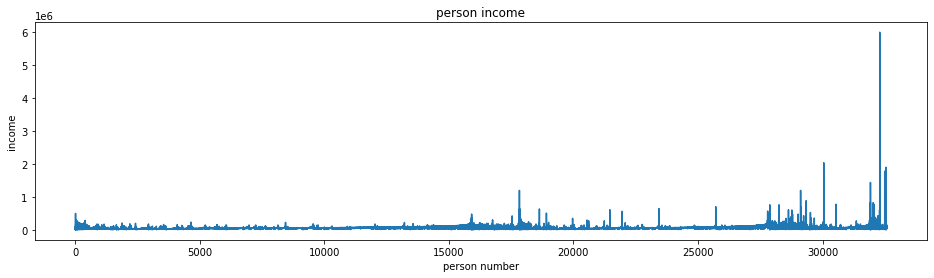

In [793]:
plt.figure(figsize=(16, 4))
plt.title('person income')
plt.xlabel('person number')
plt.ylabel('income')
plt.plot(np.arange(df.shape[0]), df['person_income'])
plt.show()

In [799]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing

Теперь применим экспоненциальное сглаживание.

In [819]:
values = df['person_income']
fit_first = SimpleExpSmoothing(values, initialization_method="estimated").fit(smoothing_level=0.2,optimized=False)
values_smooth = fit_first.fittedvalues

Гладкая кривая.

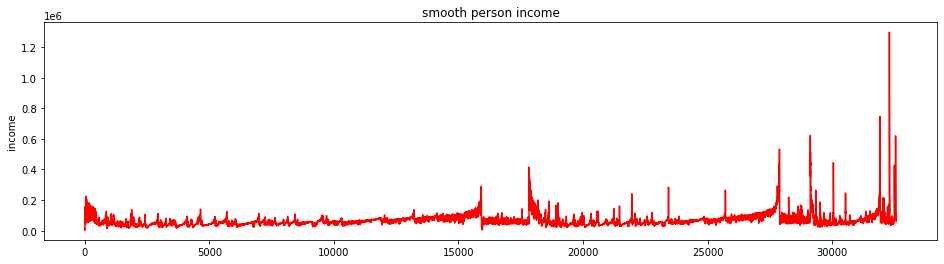

In [825]:
plt.figure(figsize=(16, 4))
plt.title('smooth person income')
plt.plot(np.arange(len(values_smooth)), values_smooth, c='red')
plt.ylabel('income')
plt.show()

На одном графике.

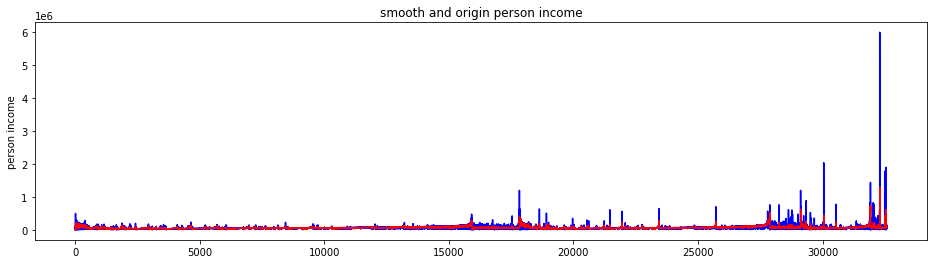

In [828]:
plt.figure(figsize=(16, 4))
plt.title('smooth and origin person income')
plt.plot(np.arange(len(values)), values, c='blue', label='origin')
plt.plot(np.arange(len(values_smooth)), values_smooth, c='red', label='smooth')
plt.ylabel('person income')
plt.show()

Можно сделать следующие выводы, что экспоненциальное сглаживание позволяет уменьшить дисперсию данных, тем самым давая нам возможность строить более робастные модели. Так же в некоторой мере мы избавляемся от выбрсов в данных, которые могут сильно влиять на качество алгоритмов машинного обучения.